### **Import Library and Images**

**Import library**

In [59]:
# library for developed algorithm
import os
import numpy as np
import matplotlib.pyplot as plt

# Image processing library for algorithm comparison
import pandas as pd
import seaborn as sns
from skimage.io import imread
from skimage.filters import rank
from skimage.morphology import disk
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from skimage.restoration import denoise_wavelet, estimate_sigma
import matplotlib.patheffects as path_effects

**Read image path**

In [60]:
# Image for reading PGM image
PGM_types_path = "PGM_types"
PGM_types_list = []
for root, dirs, files in os.walk(PGM_types_path):
    for file in files:
        if file.lower().endswith('.pgm'):
            full_path = os.path.join(root, file)
            PGM_types_list.append(full_path)

In [61]:
# Image for denoising image
dataset_path = "Dataset"
noisy1_list, noisy2_list, noisy3_list, noisy4_list, original_list = ([] for i in range(5))
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        full_path = os.path.join(root, file)
        if file.lower().endswith('.pgm'):
            if root.split('/')[-1] == 'noisy_1':
                noisy1_list.append(full_path)
            elif root.split('/')[-1] == 'noisy_2':
                noisy2_list.append(full_path)
            elif root.split('/')[-1] == 'noisy_3':
                noisy3_list.append(full_path)
            elif root.split('/')[-1] == 'noisy_4':
                noisy4_list.append(full_path)
            elif root.split('/')[-1] == 'original':
                original_list.append(full_path)

### **TASK 1: Image reading and displaying**

In [62]:
# Read PGM image
def read_pgm(filepath):

    with open(filepath, 'rb') as file: # open the file in binary mode

        # Read row by row until collect all the information detail
        info = 0 # index for identifying information detail
        while info < 3:
            line = file.readline().strip()
            if isinstance(line, bytes) and line.startswith(b'#'): # ignore comments
                continue
            elif info == 0:
                if len(line.split()) == 1:
                    filetype = line.decode('utf-8')
                    info += 1
                elif len(line.split()) == 4:
                    filetype = line.split()[0].decode('utf-8')
                    ncolumn, nrow = int(line.split()[1]), int(line.split()[2])
                    max_gray = int(line.split()[3])
                    break
                else:
                    raise ValueError("The file structure not support")

            elif info == 1:
                # Read dimension of image
                dimensions = line.split()
                ncolumn, nrow = int(dimensions[0]), int(dimensions[1])
                info += 1
            elif info == 2:
                # Read maximum gray level
                max_gray = int(line)
                info += 1

        # Reading method for P5 type
        if filetype == 'P5':
            pixel_data_line = file.readlines()
            # Iterating over a bytes object to create decimal
            pixel_data = []
            for line in pixel_data_line:
                pixel_data += line
        # Reading method for P2 type
        elif filetype == 'P2':
            pixel_data_line = file.readlines()
            # Concat all decimal in one list
            pixel_data = [value for line in pixel_data_line for value in line.split()]
        else: # if other format is detected
            raise ValueError("Only P2 and P5 PGM format is supported.")

        # Arrange image array to match width*height
        if len(pixel_data) == ncolumn*nrow:
            img = np.zeros((nrow,ncolumn))
            index = 0
            for row in range(nrow):
                for col in range(ncolumn):
                    img[row, col] = pixel_data[index]
                    index += 1
        else:
            raise ValueError("Total pixels not match.")

    return img.astype(np.uint8)

#### **Functional test**


This section aims to test the `read_pgm()` function on various types of PGM files. The test includes three types of PGM images: P2, P5 with headers segmented by spaces, and P5 with headers segmented by tabs. The images are then displayed using the `imshow()` function.

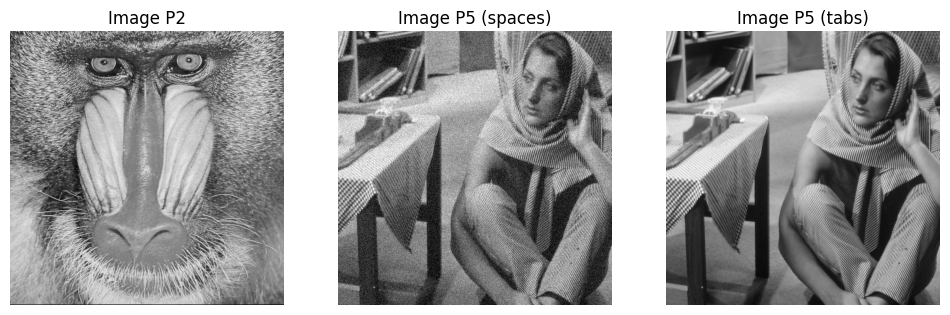

In [63]:
img_label = ['P2', 'P5 (spaces)', 'P5 (tabs)']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for i, image_path in enumerate(PGM_types_list):
    img = read_pgm(image_path)
    axes[i].imshow(img, cmap = 'gray')
    axes[i].set_title(f"Image {img_label[i]}")
    axes[i].axis("off")

### **TASK 2: Wavelet decomposition**

In [64]:
# Down sampling function
def downsampling(image, factor, type):
    if type == 'row':
        downsampled = image[::factor, :] # drop row
    elif type == 'col':
        downsampled = image[:, ::factor] # drop column

    return downsampled

# Up sampling function
def upsampling(image, factor, type):
    h, w = image.shape
    
    # Calculate padding for even dimensions if needed
    if type == 'row':
        upsampled_h = h * factor
        # If upsampled height is odd, add padding to make it even
        if upsampled_h % 2 != 0:
            upsampled_h += 1
        upsampled = np.zeros((upsampled_h, w))  # Create the upsampled image with zero padding
        upsampled[::factor, :] = image  # Insert original image rows
    elif type == 'col':
        upsampled_w = w * factor
        # If upsampled width is odd, add padding to make it even
        if upsampled_w % 2 != 0:
            upsampled_w += 1
        upsampled = np.zeros((h, upsampled_w))  # Create the upsampled image with zero padding
        upsampled[:, ::factor] = image  # Insert original image columns

    return upsampled

# Convolution function
def convolution(img_array, kernel, flip = 'False'):
    # Check size of image array and kernel
    img_height, img_width = img_array.shape
    k_height, k_width = kernel.shape

    # Flip kernel for IDWT
    if flip == 'True':
        kernel = np.flip(np.flip(kernel, axis=0), axis=1)

    # Calculate padding size
    pad_height = int(np.ceil(((img_height - 1) + k_height - img_height) / 2))
    pad_width = int(np.ceil(((img_width - 1) + k_width - img_width) / 2))
    
    # Apply padding
    padded_image = np.pad(img_array,((pad_height, pad_height), (pad_width, pad_width)), mode = 'constant')
    convolved_img = np.zeros([padded_image.shape[0], padded_image.shape[1]])
    
    # Perform convolution
    for row in range(padded_image.shape[0]):
        for col in range(padded_image.shape[1]):
            sliced_image = padded_image[row : row + k_height,
                                        col : col + k_width ]
            convolved_img[row, col] = np.sum(sliced_image * kernel)

    if flip == 'True': # Kernel flip make shift at the right and bottom
        convolved_img = convolved_img[0:img_height-pad_height+1, 0:img_width-pad_width+1]
    else: # No kernel flip make shift at the left and top
        convolved_img = convolved_img[pad_height:pad_height + img_height, pad_width:pad_width + img_width]

    return convolved_img

In [65]:
# Validation function
def validation(original_img, approximated_img, report = True):
    mse = mean_squared_error(original_img.flatten(), approximated_img.flatten())
    if report:
        print(f'Mean Squared Error (MSE) between original and reconstructed image: {mse}')

    ssim_index, ssim_map = ssim(original_img, approximated_img, full=True,
                                data_range=original_img.max() - original_img.min())
    if report:
        print(f"SSIM Index between original and reconstructed image: {ssim_index}")

    return mse, ssim_index, ssim_map

**Forward discrete wavelet transform (FDWT)**

In [66]:
def FDWT(img_array, levels):

    if img_array.shape[0] % 2 != 0 or img_array.shape[1] % 2 != 0:
        pad_height = 1 if img_array.shape[0] % 2 != 0 else 0
        pad_width = 1 if img_array.shape[1] % 2 != 0 else 0
        img_array = np.pad(img_array, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

    # Haar kernel
    LP_kernel = np.array([[1 / np.sqrt(2), 1 / np.sqrt(2)]])
    HP_kernel = np.array([[1 / np.sqrt(2), - 1 / np.sqrt(2)]])
    
    results = []
    for level in range(levels):
        # Apply LP and HP filters along rows and downsample by col
        L_img = downsampling(convolution(img_array, LP_kernel), 2, 'col')
        H_img = downsampling(convolution(img_array, HP_kernel), 2, 'col')

        # Apply LP and HP filters along columns and downsample by row
        LL_img = downsampling(convolution(L_img, LP_kernel.T), 2, 'row')
        LH_img = downsampling(convolution(L_img, HP_kernel.T), 2, 'row')
        HL_img = downsampling(convolution(H_img, LP_kernel.T), 2, 'row')
        HH_img = downsampling(convolution(H_img, HP_kernel.T), 2, 'row')

        # Store coefficient in list
        results.append([LL_img, LH_img, HL_img, HH_img])
        # Update for the next level
        img_array = LL_img

    return results

**Inverse discrete wavelet transform (IDWT)**

In [67]:
def IDWT(coeffs):
    levels =  len(coeffs)
    LP_kernel = np.array([[1 / np.sqrt(2), 1 / np.sqrt(2)]])
    HP_kernel = np.array([[1 / np.sqrt(2), - 1 / np.sqrt(2)]])

    i = levels - 1
    flag_loop = False
    while i >= 0:
        LL_img, LH_img, HL_img, HH_img = coeffs[i]
        LL_img = approximated_img[:LL_img.shape[0], :LL_img.shape[1]] if flag_loop else LL_img

        # Low component image reconstruction
        LL_img_reconstruct = upsampling(LL_img, 2, 'row')
        LL_img_reconstruct = convolution(LL_img_reconstruct, LP_kernel.T, flip='True')
        LH_img_reconstruct = upsampling(LH_img, 2, 'row')
        LH_img_reconstruct = convolution(LH_img_reconstruct, HP_kernel.T, flip='True')

        Low_img = LL_img_reconstruct + LH_img_reconstruct
        Low_img = upsampling(Low_img, 2, 'col')
        Low_img = convolution(Low_img, LP_kernel, flip='True')

        # High component image reconstruction`  `
        HL_img_reconstruct = upsampling(HL_img, 2, 'row')
        HL_img_reconstruct = convolution(HL_img_reconstruct, LP_kernel.T, flip='True')
        HH_img_reconstruct = upsampling(HH_img, 2, 'row')
        HH_img_reconstruct = convolution(HH_img_reconstruct, HP_kernel.T, flip='True')

        High_img = HL_img_reconstruct + HH_img_reconstruct
        High_img = upsampling(High_img, 2, 'col')
        High_img = convolution(High_img, HP_kernel, flip='True')

        # Combine low and high components to get the reconstructed image at this level
        approximated_img = Low_img + High_img
        flag_loop = True
        i-=1

    return approximated_img

#### **Functional test**

This section aims to test forward discrete wavelet transform and inverse discrete wavelet transform functions.  All images from original folder are selected for this test to apply 3 level of decomposition and validate the reconstrusted images using Mean Square Error (MSE).

In [68]:
filename_list = []
mse_list = []
print("Processing...")
for path in original_list:
    image = read_pgm(path)
    coeffs = FDWT(image, 3)
    reconstructed_image = IDWT(coeffs)
    mse = mean_squared_error(image.flatten(), reconstructed_image[:image.shape[0], :image.shape[1]].flatten())
    filename_list.append(path.split("/")[-1])
    mse_list.append(mse)

print(f'Average MSE between original and reconstructed image: {sum(mse_list)/len(mse_list)}')
print(f'Minimum MSE between original and reconstructed image: {min(mse_list)}')
print(f'Maximum MSE between original and reconstructed image: {max(mse_list)}')

Processing...
Average MSE between original and reconstructed image: 2.0883186135982727e-26
Minimum MSE between original and reconstructed image: 1.0447975391760552e-26
Maximum MSE between original and reconstructed image: 4.620898891896257e-26


### **TASK 3: Image denoising**

In [69]:
# Median filtering
def median_filter(img, matrix_size):
    length = matrix_size // 2  # Half of the filter size
    median_img = np.zeros([img.shape[0], img.shape[1]])  # Initialize output image

    # Pad the image to handle boundary conditions
    padded_img = np.pad(img, ((length, length), (length, length)), mode='constant', constant_values=0)

    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            # Extract the neighborhood and flatten
            neighbor_list = padded_img[row:row + matrix_size, col:col + matrix_size].flatten()
            # Sort all neighbor
            neighbor_list.sort()
            # Replace the center pixel
            median_img[row, col] = neighbor_list[len(neighbor_list) // 2]
    
    return median_img

# Denoising function
def denoise(noisy_img, original_img, levels, plot_ssim = False):

    median_image = median_filter(noisy_img, 3) # apply median filter
    coefficient_fwt = FDWT(median_image, levels) # apply FWT
    denoise_coeff = []
    for level in range(len(coefficient_fwt)):
        LL_coeff, LH_coeff, HL_coeff, HH_coeff = coefficient_fwt[level]
        # Universal Threshold Estimation
        sigma_noise = np.median(np.abs(HH_coeff))/0.6745
        universal_th = sigma_noise * np.sqrt(2 * np.log(HH_coeff.shape[0]))

        # Calculate new threshold (Biswas M et al 2012)
        G = [np.sum(LH_coeff), np.sum(HL_coeff), np.sum(HH_coeff)]  # Calculate G(q)
        k = len(coefficient_fwt)
        M_hat = HH_coeff.shape[0]/(2^k)
        S = np.sum(G)/M_hat # Calculate S
        P = np.exp((universal_th - S)/(universal_th + S)) # Calculate P
        threshold = sigma_noise*P

        # Apply soft thresholding to only detail coefficient
        LH_coeff_th = np.sign(LH_coeff) * np.maximum(np.abs(LH_coeff) - threshold, 0)
        HL_coeff_th = np.sign(HL_coeff) * np.maximum(np.abs(HL_coeff) - threshold, 0)
        HH_coeff_th = np.sign(HH_coeff) * np.maximum(np.abs(HH_coeff) - threshold, 0)
        
        # Store denoise coefficient in list
        denoise_coeff.append([LL_coeff, LH_coeff_th, HL_coeff_th, HH_coeff_th])

    reconstructed_image = IDWT(denoise_coeff)
    reconstructed_image = reconstructed_image.astype('uint8')

    mse, ssim_index, ssim_map = validation(original_img.flatten(), 
                                           reconstructed_image[:original_img.shape[0], :original_img.shape[1]].flatten(), #For odd width or height image
                                           report = False)

    if plot_ssim == True:
        plt.imshow(ssim_map, cmap='gray')
        plt.colorbar()
        plt.title('SSIM Map')
        plt.show()
        
    return reconstructed_image, mse, ssim_index

#### **Functional test**

This section aims to test the `denoise()` function and compare its performance with the mean filter, median filter, and the `VisuShrink` and `BayesShrink` methods provided by the scikit-image library. All images from the dataset are selected for this test and evaluated the performance using the Mean Squared Error (MSE) and Structural Similarity Index (SSIM). To calculate the MSE, the results from the BayesShrink and VisuShrink libraries will be converted into np.uint8 type before validation. Additionally, if the original image has an even size, the denoised image will be cropped to match the original dimensions.

**Proposed Method**

In [70]:
reconstructed_noisy1_list, mse_noisy1_list, ssim_noisy1_list = ([] for i in range(3))
reconstructed_noisy2_list, mse_noisy2_list, ssim_noisy2_list = ([] for i in range(3))
reconstructed_noisy3_list, mse_noisy3_list, ssim_noisy3_list = ([] for i in range(3))
reconstructed_noisy4_list, mse_noisy4_list, ssim_noisy4_list = ([] for i in range(3))

for i in range(len(original_list)):
    # Original image
    original_image = read_pgm(original_list[i])

    # Noisy 1 image
    noisy1_image = read_pgm(noisy1_list[i])
    reconstructed_noisy1, mse_noisy1, ssim_noisy1 = denoise(noisy1_image, original_image, levels = 3)
    reconstructed_noisy1_list.append(reconstructed_noisy1)
    mse_noisy1_list.append(mse_noisy1)
    ssim_noisy1_list.append(ssim_noisy1)

    # Noisy 2 image
    noisy2_image = read_pgm(noisy2_list[i])
    reconstructed_noisy2, mse_noisy2, ssim_noisy2 = denoise(noisy2_image, original_image, levels = 3)
    reconstructed_noisy2_list.append(reconstructed_noisy2)
    mse_noisy2_list.append(mse_noisy2)
    ssim_noisy2_list.append(ssim_noisy2)

    # Noisy 3 image
    noisy3_image = read_pgm(noisy3_list[i])
    reconstructed_noisy3, mse_noisy3, ssim_noisy3 = denoise(noisy3_image, original_image, levels = 3)
    reconstructed_noisy3_list.append(reconstructed_noisy3)
    mse_noisy3_list.append(mse_noisy3)
    ssim_noisy3_list.append(ssim_noisy3)

    # Noisy 4 image
    noisy4_image = read_pgm(noisy4_list[i])
    reconstructed_noisy4, mse_noisy4, ssim_noisy4 = denoise(noisy4_image, original_image, levels = 3)
    reconstructed_noisy4_list.append(reconstructed_noisy4)
    mse_noisy4_list.append(mse_noisy4)
    ssim_noisy4_list.append(ssim_noisy4)

print(f'Average MSE Noisy 1: {sum(mse_noisy1_list)/len(mse_noisy1_list)}')
print(f'Average MSE Noisy 2: {sum(mse_noisy2_list)/len(mse_noisy2_list)}')
print(f'Average MSE Noisy 3: {sum(mse_noisy3_list)/len(mse_noisy3_list)}')
print(f'Average MSE Noisy 4: {sum(mse_noisy4_list)/len(mse_noisy4_list)}')
print("")
print(f'Average SSIM Noisy 1: {sum(ssim_noisy1_list)/len(ssim_noisy1_list)}')
print(f'Average SSIM Noisy 2: {sum(ssim_noisy2_list)/len(ssim_noisy2_list)}')
print(f'Average SSIM Noisy 3: {sum(ssim_noisy3_list)/len(ssim_noisy3_list)}')
print(f'Average SSIM Noisy 4: {sum(ssim_noisy4_list)/len(ssim_noisy4_list)}')

Average MSE Noisy 1: 52.982955638654616
Average MSE Noisy 2: 61.57520946248019
Average MSE Noisy 3: 83.41661264350846
Average MSE Noisy 4: 30.60154306042266

Average SSIM Noisy 1: 0.6471659132751404
Average SSIM Noisy 2: 0.5788628159098042
Average SSIM Noisy 3: 0.353835709287371
Average SSIM Noisy 4: 0.8008791306738848


**Mean filter**

In [71]:
footprint = disk(3)
print('Kernel: ')
print(footprint)

reconstructed_noisy1_mean_list, mse_noisy1_mean_list, ssim_noisy1_mean_list = ([] for i in range(3))
reconstructed_noisy2_mean_list, mse_noisy2_mean_list, ssim_noisy2_mean_list = ([] for i in range(3))
reconstructed_noisy3_mean_list, mse_noisy3_mean_list, ssim_noisy3_mean_list = ([] for i in range(3))
reconstructed_noisy4_mean_list, mse_noisy4_mean_list, ssim_noisy4_mean_list = ([] for i in range(3))

for i in range(len(original_list)):
    # Original image
    original_image = imread(original_list[i])

    # Noisy 1 image
    noisy1_image = imread(noisy1_list[i])
    reconstructed = rank.mean(noisy1_image, footprint)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy1_mean_list.append(reconstructed)
    mse_noisy1_mean_list.append(mse)
    ssim_noisy1_mean_list.append(ssim_index)

    # Noisy 2 image
    noisy2_image = imread(noisy2_list[i])
    reconstructed = rank.mean(noisy2_image, footprint)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy2_mean_list.append(reconstructed)
    mse_noisy2_mean_list.append(mse)
    ssim_noisy2_mean_list.append(ssim_index)

    # Noisy 3 image
    noisy3_image = imread(noisy3_list[i])
    reconstructed = rank.mean(noisy3_image, footprint)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy3_mean_list.append(reconstructed)
    mse_noisy3_mean_list.append(mse)
    ssim_noisy3_mean_list.append(ssim_index)

    # Noisy 4 image
    noisy4_image = imread(noisy4_list[i])
    reconstructed = rank.mean(noisy4_image, footprint)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy4_mean_list.append(reconstructed)
    mse_noisy4_mean_list.append(mse)
    ssim_noisy4_mean_list.append(ssim_index)

print(f'Average MSE Noisy 1: {sum(mse_noisy1_mean_list)/len(mse_noisy1_mean_list)}')
print(f'Average MSE Noisy 2: {sum(mse_noisy2_mean_list)/len(mse_noisy2_mean_list)}')
print(f'Average MSE Noisy 3: {sum(mse_noisy3_mean_list)/len(mse_noisy3_mean_list)}')
print(f'Average MSE Noisy 4: {sum(mse_noisy4_mean_list)/len(mse_noisy4_mean_list)}')
print("")
print(f'Average SSIM Noisy 1: {sum(ssim_noisy1_mean_list)/len(ssim_noisy1_mean_list)}')
print(f'Average SSIM Noisy 2: {sum(ssim_noisy2_mean_list)/len(ssim_noisy2_mean_list)}')
print(f'Average SSIM Noisy 3: {sum(ssim_noisy3_mean_list)/len(ssim_noisy3_mean_list)}')
print(f'Average SSIM Noisy 4: {sum(ssim_noisy4_mean_list)/len(ssim_noisy4_mean_list)}')

Kernel: 
[[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]


Average MSE Noisy 1: 48.41157418195974
Average MSE Noisy 2: 55.576842249093765
Average MSE Noisy 3: 80.69435128804868
Average MSE Noisy 4: 59.49575106838268

Average SSIM Noisy 1: 0.6875851597559501
Average SSIM Noisy 2: 0.6490479916186335
Average SSIM Noisy 3: 0.4903013866114794
Average SSIM Noisy 4: 0.6095593121646871


**Median filter**

In [72]:
footprint = disk(3)
print('Kernel: ')
print(footprint)

reconstructed_noisy1_median_list, mse_noisy1_median_list, ssim_noisy1_median_list = ([] for i in range(3))
reconstructed_noisy2_median_list, mse_noisy2_median_list, ssim_noisy2_median_list = ([] for i in range(3))
reconstructed_noisy3_median_list, mse_noisy3_median_list, ssim_noisy3_median_list = ([] for i in range(3))
reconstructed_noisy4_median_list, mse_noisy4_median_list, ssim_noisy4_median_list = ([] for i in range(3))

for i in range(len(original_list)):
    # Original image
    original_image = imread(original_list[i])

    # Noisy 1 image
    noisy1_image = imread(noisy1_list[i])
    reconstructed = rank.median(noisy1_image, footprint)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy1_median_list.append(reconstructed)
    mse_noisy1_median_list.append(mse)
    ssim_noisy1_median_list.append(ssim_index)

    # Noisy 2 image
    noisy2_image = imread(noisy2_list[i])
    reconstructed = rank.median(noisy2_image, footprint)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy2_median_list.append(reconstructed)
    mse_noisy2_median_list.append(mse)
    ssim_noisy2_median_list.append(ssim_index)

    # Noisy 3 image
    noisy3_image = imread(noisy3_list[i])
    reconstructed = rank.median(noisy3_image, footprint)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy3_median_list.append(reconstructed)
    mse_noisy3_median_list.append(mse)
    ssim_noisy3_median_list.append(ssim_index)

    # Noisy 4 image
    noisy4_image = imread(noisy4_list[i])
    reconstructed = rank.median(noisy4_image, footprint)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy4_median_list.append(reconstructed)
    mse_noisy4_median_list.append(mse)
    ssim_noisy4_median_list.append(ssim_index)

print(f'Average MSE Noisy 1: {sum(mse_noisy1_median_list) / len(mse_noisy1_median_list)}')
print(f'Average MSE Noisy 2: {sum(mse_noisy2_median_list) / len(mse_noisy2_median_list)}')
print(f'Average MSE Noisy 3: {sum(mse_noisy3_median_list) / len(mse_noisy3_median_list)}')
print(f'Average MSE Noisy 4: {sum(mse_noisy4_median_list) / len(mse_noisy4_median_list)}')
print("")
print(f'Average SSIM Noisy 1: {sum(ssim_noisy1_median_list) / len(ssim_noisy1_median_list)}')
print(f'Average SSIM Noisy 2: {sum(ssim_noisy2_median_list) / len(ssim_noisy2_median_list)}')
print(f'Average SSIM Noisy 3: {sum(ssim_noisy3_median_list) / len(ssim_noisy3_median_list)}')
print(f'Average SSIM Noisy 4: {sum(ssim_noisy4_median_list) / len(ssim_noisy4_median_list)}')


Kernel: 
[[0 0 0 1 0 0 0]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0]
 [0 1 1 1 1 1 0]
 [0 0 0 1 0 0 0]]
Average MSE Noisy 1: 48.144615220282816
Average MSE Noisy 2: 56.60058510126817
Average MSE Noisy 3: 79.92087589909599
Average MSE Noisy 4: 32.08867712216442

Average SSIM Noisy 1: 0.68122276475406
Average SSIM Noisy 2: 0.625889327804822
Average SSIM Noisy 3: 0.4255156980079044
Average SSIM Noisy 4: 0.7678103955359782


**BayeShrink**

In [73]:
reconstructed_noisy1_bay_list, mse_noisy1_bay_list, ssim_noisy1_bay_list = ([] for i in range(3))
reconstructed_noisy2_bay_list, mse_noisy2_bay_list, ssim_noisy2_bay_list = ([] for i in range(3))
reconstructed_noisy3_bay_list, mse_noisy3_bay_list, ssim_noisy3_bay_list = ([] for i in range(3))
reconstructed_noisy4_bay_list, mse_noisy4_bay_list, ssim_noisy4_bay_list = ([] for i in range(3))

for i in range(len(original_list)):
    # Original image
    original_image = imread(original_list[i])

    # Noisy 1 image
    noisy1_image = imread(noisy1_list[i])
    sigma_est = estimate_sigma(noisy1_image, channel_axis=-1, average_sigmas=True)
    reconstructed = denoise_wavelet(noisy1_image, channel_axis=None, convert2ycbcr=False,
                               method='BayesShrink', mode='soft', rescale_sigma=True,)
    reconstructed = (reconstructed * 255).astype(np.uint8)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy1_bay_list.append(reconstructed)
    mse_noisy1_bay_list.append(mse)
    ssim_noisy1_bay_list.append(ssim_index)

    # Noisy 2 image
    noisy2_image = imread(noisy2_list[i])
    sigma_est = estimate_sigma(noisy2_image, channel_axis=-1, average_sigmas=True)
    reconstructed = denoise_wavelet(noisy2_image, channel_axis=None, convert2ycbcr=False,
                               method='BayesShrink', mode='soft', rescale_sigma=True,)
    reconstructed = (reconstructed * 255).astype(np.uint8)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy2_bay_list.append(reconstructed)
    mse_noisy2_bay_list.append(mse)
    ssim_noisy2_bay_list.append(ssim_index)

    # Noisy 3 image
    noisy3_image = imread(noisy3_list[i])
    sigma_est = estimate_sigma(noisy3_image, channel_axis=-1, average_sigmas=True)
    reconstructed = denoise_wavelet(noisy3_image, channel_axis=None, convert2ycbcr=False,
                               method='BayesShrink', mode='soft', rescale_sigma=True,)
    reconstructed = (reconstructed * 255).astype(np.uint8)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy3_bay_list.append(reconstructed)
    mse_noisy3_bay_list.append(mse)
    ssim_noisy3_bay_list.append(ssim_index)

    # Noisy 4 image
    noisy4_image = imread(noisy4_list[i])
    sigma_est = estimate_sigma(noisy4_image, channel_axis=-1, average_sigmas=True)
    reconstructed = denoise_wavelet(noisy4_image, channel_axis=None, convert2ycbcr=False,
                               method='BayesShrink', mode='soft', rescale_sigma=True,)
    reconstructed = (reconstructed * 255).astype(np.uint8)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy4_bay_list.append(reconstructed)
    mse_noisy4_bay_list.append(mse)
    ssim_noisy4_bay_list.append(ssim_index)

print(f'Average MSE Noisy 1: {sum(mse_noisy1_bay_list) / len(mse_noisy1_bay_list)}')
print(f'Average MSE Noisy 2: {sum(mse_noisy2_bay_list) / len(mse_noisy2_bay_list)}')
print(f'Average MSE Noisy 3: {sum(mse_noisy3_bay_list) / len(mse_noisy3_bay_list)}')
print(f'Average MSE Noisy 4: {sum(mse_noisy4_bay_list) / len(mse_noisy4_bay_list)}')
print("")
print(f'Average SSIM Noisy 1: {sum(ssim_noisy1_bay_list) / len(ssim_noisy1_bay_list)}')
print(f'Average SSIM Noisy 2: {sum(ssim_noisy2_bay_list) / len(ssim_noisy2_bay_list)}')
print(f'Average SSIM Noisy 3: {sum(ssim_noisy3_bay_list) / len(ssim_noisy3_bay_list)}')
print(f'Average SSIM Noisy 4: {sum(ssim_noisy4_bay_list) / len(ssim_noisy4_bay_list)}')

Average MSE Noisy 1: 50.73369922722226
Average MSE Noisy 2: 59.005616300786926
Average MSE Noisy 3: 79.60616740750459
Average MSE Noisy 4: 6.770653295891389

Average SSIM Noisy 1: 0.7337393241760498
Average SSIM Noisy 2: 0.6667178963531051
Average SSIM Noisy 3: 0.5180414877081905
Average SSIM Noisy 4: 0.3938967458100354


**VisuShrink**

In [74]:
reconstructed_noisy1_visu_list, mse_noisy1_visu_list, ssim_noisy1_visu_list = ([] for i in range(3))
reconstructed_noisy2_visu_list, mse_noisy2_visu_list, ssim_noisy2_visu_list = ([] for i in range(3))
reconstructed_noisy3_visu_list, mse_noisy3_visu_list, ssim_noisy3_visu_list = ([] for i in range(3))
reconstructed_noisy4_visu_list, mse_noisy4_visu_list, ssim_noisy4_visu_list = ([] for i in range(3))

for i in range(len(original_list)):
    # Original image
    original_image = imread(original_list[i])

    # Noisy 1 image
    noisy1_image = imread(noisy1_list[i])
    sigma_est = estimate_sigma(noisy1_image, channel_axis=-1, average_sigmas=True)
    reconstructed = denoise_wavelet(noisy1_image, channel_axis=None, convert2ycbcr=False,
                                    method='VisuShrink', mode='soft', rescale_sigma=True,)
    reconstructed = (reconstructed * 255).astype(np.uint8)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy1_visu_list.append(reconstructed)
    mse_noisy1_visu_list.append(mse)
    ssim_noisy1_visu_list.append(ssim_index)

    # Noisy 2 image
    noisy2_image = imread(noisy2_list[i])
    sigma_est = estimate_sigma(noisy2_image, channel_axis=-1, average_sigmas=True)
    reconstructed = denoise_wavelet(noisy2_image, channel_axis=None, convert2ycbcr=False,
                                    method='VisuShrink', mode='soft', rescale_sigma=True,)
    reconstructed = (reconstructed * 255).astype(np.uint8)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy2_visu_list.append(reconstructed)
    mse_noisy2_visu_list.append(mse)
    ssim_noisy2_visu_list.append(ssim_index)

    # Noisy 3 image
    noisy3_image = imread(noisy3_list[i])
    sigma_est = estimate_sigma(noisy3_image, channel_axis=-1, average_sigmas=True)
    reconstructed = denoise_wavelet(noisy3_image, channel_axis=None, convert2ycbcr=False,
                                    method='VisuShrink', mode='soft', rescale_sigma=True,)
    reconstructed = (reconstructed * 255).astype(np.uint8)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy3_visu_list.append(reconstructed)
    mse_noisy3_visu_list.append(mse)
    ssim_noisy3_visu_list.append(ssim_index)

    # Noisy 4 image
    noisy4_image = imread(noisy4_list[i])
    sigma_est = estimate_sigma(noisy4_image, channel_axis=-1, average_sigmas=True)
    reconstructed = denoise_wavelet(noisy4_image, channel_axis=None, convert2ycbcr=False,
                                    method='VisuShrink', mode='soft', rescale_sigma=True,)
    reconstructed = (reconstructed * 255).astype(np.uint8)
    mse, ssim_index, _ = validation(original_image,
                                    reconstructed[:original_image.shape[0],:original_image.shape[1]],
                                    report = False)
    reconstructed_noisy4_visu_list.append(reconstructed)
    mse_noisy4_visu_list.append(mse)
    ssim_noisy4_visu_list.append(ssim_index)

print(f'Average MSE Noisy 1: {sum(mse_noisy1_visu_list) / len(mse_noisy1_visu_list)}')
print(f'Average MSE Noisy 2: {sum(mse_noisy2_visu_list) / len(mse_noisy2_visu_list)}')
print(f'Average MSE Noisy 3: {sum(mse_noisy3_visu_list) / len(mse_noisy3_visu_list)}')
print(f'Average MSE Noisy 4: {sum(mse_noisy4_visu_list) / len(mse_noisy4_visu_list)}')
print("")
print(f'Average SSIM Noisy 1: {sum(ssim_noisy1_visu_list) / len(ssim_noisy1_visu_list)}')
print(f'Average SSIM Noisy 2: {sum(ssim_noisy2_visu_list) / len(ssim_noisy2_visu_list)}')
print(f'Average SSIM Noisy 3: {sum(ssim_noisy3_visu_list) / len(ssim_noisy3_visu_list)}')
print(f'Average SSIM Noisy 4: {sum(ssim_noisy4_visu_list) / len(ssim_noisy4_visu_list)}')

Average MSE Noisy 1: 69.17339777651493
Average MSE Noisy 2: 74.74463705926696
Average MSE Noisy 3: 90.48150224567478
Average MSE Noisy 4: 44.58797724199729

Average SSIM Noisy 1: 0.5573222779774148
Average SSIM Noisy 2: 0.5151590363052417
Average SSIM Noisy 3: 0.43428604290967693
Average SSIM Noisy 4: 0.38518039918633196


#### **Evaluation**

In [102]:
image_label = [item.split('/')[-1] for i in range(4) for item in original_list]
noise_label = ['Noisy 1' for i in range(len(mse_noisy1_list))] + ['Noisy 2' for i in range(len(mse_noisy1_list))] + ['Noisy 3' for i in range(len(mse_noisy1_list))]+ ['Noisy 4' for i in range(len(mse_noisy1_list))]

mse_developed_algo = mse_noisy1_list + mse_noisy2_list + mse_noisy3_list + mse_noisy4_list
mse_mean_algo = mse_noisy1_mean_list + mse_noisy2_mean_list +  mse_noisy3_mean_list + mse_noisy4_mean_list
mse_median_algo = mse_noisy1_median_list + mse_noisy2_median_list +  mse_noisy3_median_list + mse_noisy4_median_list
mse_bay_algo = mse_noisy1_bay_list + mse_noisy2_bay_list +  mse_noisy3_bay_list + mse_noisy4_bay_list
mse_visu_algo = mse_noisy1_visu_list + mse_noisy2_visu_list +  mse_noisy3_visu_list + mse_noisy4_visu_list

ssim_developed_algo = ssim_noisy1_list + ssim_noisy2_list + ssim_noisy3_list + ssim_noisy4_list
ssim_mean_algo = ssim_noisy1_mean_list + ssim_noisy2_mean_list +  ssim_noisy3_mean_list + ssim_noisy4_mean_list
ssim_median_algo = ssim_noisy1_median_list + ssim_noisy2_median_list +  ssim_noisy3_median_list + ssim_noisy4_median_list
ssim_bay_algo = ssim_noisy1_bay_list + ssim_noisy2_bay_list +  ssim_noisy3_bay_list + ssim_noisy4_bay_list
ssim_visu_algo = ssim_noisy1_visu_list + ssim_noisy2_visu_list +  ssim_noisy3_visu_list + ssim_noisy4_visu_list

data = []
# MSE data
for name, noise, developed, mean, median, bay, visu in zip(
    image_label, noise_label, mse_developed_algo, mse_mean_algo, mse_median_algo, mse_bay_algo, mse_visu_algo
):
    data.append([name, noise, developed, 'MSE', 'Proposed Algorithm'])
    data.append([name, noise, mean, 'MSE', 'Mean Filter'])
    data.append([name, noise, median, 'MSE', 'Median Filter'])
    data.append([name, noise, bay, 'MSE', 'BayeShrink'])
    data.append([name, noise, visu, 'MSE', 'VisuShrink'])

# SSIM data
for name, noise, developed, mean, median, bay, visu in zip(
    image_label, noise_label, ssim_developed_algo, ssim_mean_algo, ssim_median_algo, ssim_bay_algo, ssim_visu_algo
):
    data.append([name, noise, developed, 'SSIM', 'Proposed Algorithm'])
    data.append([name, noise, mean, 'SSIM', 'Mean Filter'])
    data.append([name, noise, median, 'SSIM', 'Median Filter'])
    data.append([name, noise, bay, 'SSIM', 'BayeShrink'])
    data.append([name, noise, visu, 'SSIM', 'VisuShrink'])

df_results = pd.DataFrame(data, columns=['Image','Noise_type', 'Value', 'Metric', 'Algorithm'])
df_results.to_csv('Evaluation_results.csv')

In [103]:
df_results.groupby(['Noise_type', 'Metric', 'Algorithm']).describe()

Value                                   \
                                     count       mean        std        min   
Noise_type Metric Algorithm                                                   
Noisy 1    MSE    BayeShrink          19.0  50.733699  13.266119  22.463862   
                  Mean Filter         19.0  48.411574  17.209820  18.110876   
                  Median Filter       19.0  48.144615  15.565774  21.764839   
                  Proposed Algorithm  19.0  52.982956  13.546145  33.381225   
                  VisuShrink          19.0  69.173398  14.330203  40.987028   
           SSIM   BayeShrink          19.0   0.733739   0.050715   0.662030   
                  Mean Filter         19.0   0.687585   0.118757   0.427724   
                  Median Filter       19.0   0.681223   0.106110   0.428360   
                  Proposed Algorithm  19.0   0.647166   0.093669   0.344602   
                  VisuShrink          19.0   0.557322   0.122776   0.244826   
Noisy 2    MSE    BayeShrink          19.0  59.005616  12.719827  33.368728   
                  Mean Filter         19.0  55.576842  14.378260  27.705340   
                  Median Filter       19.0  56.600585  12.839601  35.079779   
                  Proposed Algorithm  19.0  61.575209  11.380445  42.590126   
                  VisuShrink          19.0  74.744637  13.689028  48.058749   
           SSIM   BayeShrink          19.0   0.666718   0.061525   0.545813   
                  Mean Filter         19.0   0.649048   0.105251   0.414493   
                  Median Filter       19.0   0.625889   0.090546   0.408802   
                  Proposed Algorithm  19.0   0.578863   0.079987   0.325046   
                  VisuShrink          19.0   0.515159   0.124914   0.215743   
Noisy 3    MSE    BayeShrink          19.0  79.606167   8.762771  60.505845   
                  Mean Filter         19.0  80.694351   6.280744  68.249388   
                  Median Filter       19.0  79.920876   5.949794  69.423332   
                  Proposed Algorithm  19.0  83.416613   5.871004  72.795144   
                  VisuShrink          19.0  90.481502   9.394045  71.294991   
           SSIM   BayeShrink          19.0   0.518041   0.090030   0.306481   
                  Mean Filter         19.0   0.490301   0.062697   0.350307   
                  Median Filter       19.0   0.425516   0.055858   0.320293   
                  Proposed Algorithm  19.0   0.353836   0.076763   0.226799   
                  VisuShrink          19.0   0.434286   0.129021   0.170901   
Noisy 4    MSE    BayeShrink          19.0   6.770653   3.877427   4.738682   
                  Mean Filter         19.0  59.495751  13.095417  38.439967   
                  Median Filter       19.0  32.088677  17.634683   4.079607   
                  Proposed Algorithm  19.0  30.601543  21.998378   2.261658   
                  VisuShrink          19.0  44.587977  22.884023   8.359618   
           SSIM   BayeShrink          19.0   0.393897   0.090616   0.250968   
                  Mean Filter         19.0   0.609559   0.089714   0.400322   
                  Median Filter       19.0   0.767810   0.138266   0.448257   
                  Proposed Algorithm  19.0   0.800879   0.134233   0.422423   
                  VisuShrink          19.0   0.385180   0.076050   0.274945   

                                                                       \
                                            25%        50%        75%   
Noise_type Metric Algorithm                                             
Noisy 1    MSE    BayeShrink          45.851609  51.653866  58.691631   
                  Mean Filter         38.523783  49.533137  56.279741   
                  Median Filter       37.860696  46.940697  56.273582   
                  Proposed Algorithm  44.639025  51.014038  60.607327   
                  VisuShrink          60.670013  69.380310  77.731805   
           SSIM   BayeShrink           0.707513   0.722

**Exploring denoised image**

In [104]:
# Path of images
original_path = 'Dataset/original/bridge.pgm'
original_image = read_pgm(original_path)

noisy1_path = 'Dataset/noisy_1/bridge.pgm'
noisy1_image = read_pgm(noisy1_path)

noisy2_path = 'Dataset/noisy_2/bridge.pgm'
noisy2_image = read_pgm(noisy2_path)

noisy3_path = 'Dataset/noisy_3/bridge.pgm'
noisy3_image = read_pgm(noisy3_path)

noisy4_path = 'Dataset/noisy_4/bridge.pgm'
noisy4_image = read_pgm(noisy4_path)

Mean Squared Error (MSE) between original and reconstructed image:  67.79154968261719
SSIM Index between original and reconstructed image:  0.6184105340573317


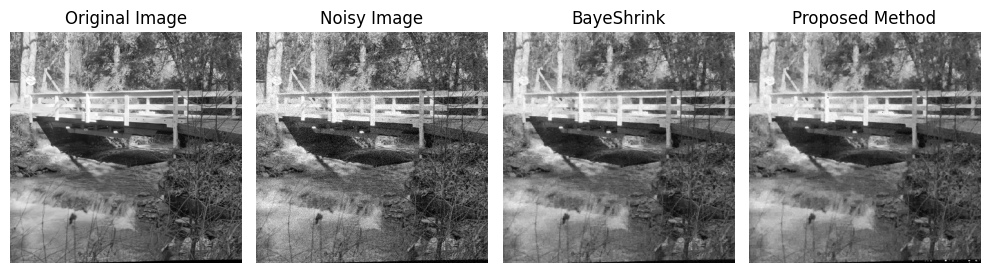

Mean Squared Error (MSE) between original and reconstructed image:  74.3249397277832
SSIM Index between original and reconstructed image:  0.5557270069356696


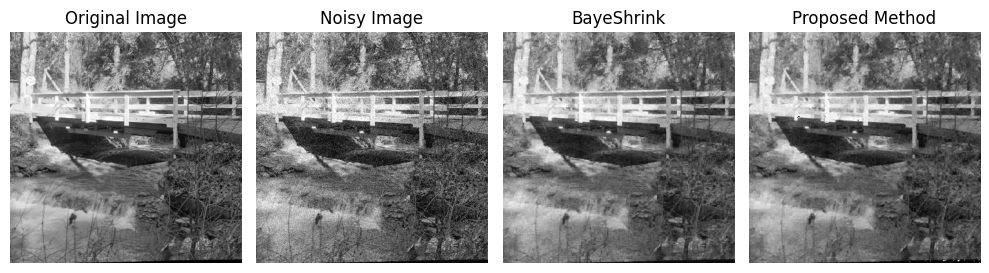

Mean Squared Error (MSE) between original and reconstructed image:  88.77203369140625
SSIM Index between original and reconstructed image:  0.36876412614174736


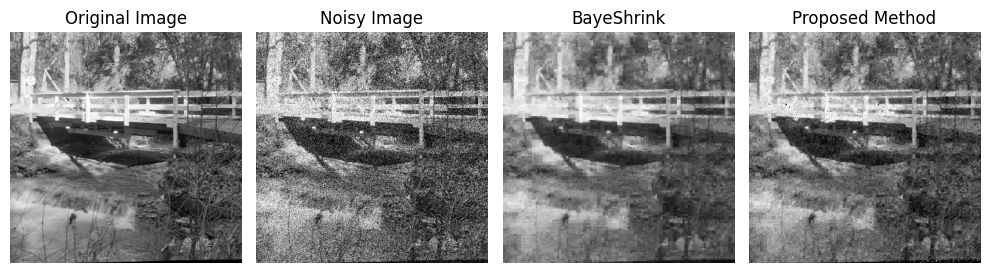

Mean Squared Error (MSE) between original and reconstructed image:  49.83267593383789
SSIM Index between original and reconstructed image:  0.7210927613955036


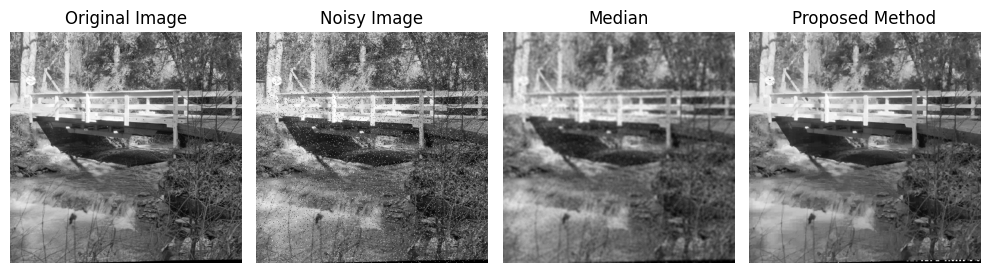

In [105]:
# Applying denoise function
reconstructed_noisy1, mse_noisy1, ssim_noisy1 = denoise(noisy1_image, original_image, levels = 3)
print('Mean Squared Error (MSE) between original and reconstructed image: ', mse_noisy1)
print('SSIM Index between original and reconstructed image: ', ssim_noisy1)
# BayeShrink
sigma_est = estimate_sigma(noisy1_image, channel_axis=-1, average_sigmas=True)
reconstructed = denoise_wavelet(noisy1_image, channel_axis=None, convert2ycbcr=False,
                            method='BayesShrink', mode='soft', rescale_sigma=True,)

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
# Display the original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')
# Display the noise image
axes[1].imshow(noisy1_image, cmap='gray')
axes[1].set_title("Noisy Image")
axes[1].axis('off')
# Display the reconstructed image
axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title("BayeShrink")
axes[2].axis('off')
# Display the reconstructed image
axes[3].imshow(reconstructed_noisy1, cmap='gray')
axes[3].set_title("Proposed Method")
axes[3].axis('off')
plt.tight_layout()
plt.show()

reconstructed_noisy2, mse_noisy2, ssim_noisy2 = denoise(noisy2_image, original_image, levels = 3)
print('Mean Squared Error (MSE) between original and reconstructed image: ', mse_noisy2)
print('SSIM Index between original and reconstructed image: ', ssim_noisy2)
# BayeShrink
sigma_est = estimate_sigma(noisy2_image, channel_axis=-1, average_sigmas=True)
reconstructed = denoise_wavelet(noisy2_image, channel_axis=None, convert2ycbcr=False,
                            method='BayesShrink', mode='soft', rescale_sigma=True,)
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
# Display the original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')
# Display the noise image
axes[1].imshow(noisy2_image, cmap='gray')
axes[1].set_title("Noisy Image")
axes[1].axis('off')
# Display the reconstructed image
axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title("BayeShrink")
axes[2].axis('off')
# Display the reconstructed image
axes[3].imshow(reconstructed_noisy2, cmap='gray')
axes[3].set_title("Proposed Method")
axes[3].axis('off')
plt.tight_layout()
plt.show()

reconstructed_noisy3, mse_noisy3, ssim_noisy3 = denoise(noisy3_image, original_image, levels = 3)
print('Mean Squared Error (MSE) between original and reconstructed image: ', mse_noisy3)
print('SSIM Index between original and reconstructed image: ', ssim_noisy3)
# BayeShrink
sigma_est = estimate_sigma(noisy3_image, channel_axis=-1, average_sigmas=True)
reconstructed = denoise_wavelet(noisy3_image, channel_axis=None, convert2ycbcr=False,
                            method='BayesShrink', mode='soft', rescale_sigma=True,)
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
# Display the original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')
# Display the noise image
axes[1].imshow(noisy3_image, cmap='gray')
axes[1].set_title("Noisy Image")
axes[1].axis('off')
# Display the reconstructed image
axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title("BayeShrink")
axes[2].axis('off')
# Display the reconstructed image
axes[3].imshow(reconstructed_noisy3, cmap='gray')
axes[3].set_title("Proposed Method")
axes[3].axis('off')
plt.tight_layout()
plt.show()

reconstructed_noisy4, mse_noisy4, ssim_noisy4 = denoise(noisy4_image, original_image, levels = 3)
print('Mean Squared Error (MSE) between original and reconstructed image: ', mse_noisy4)
print('SSIM Index between original and reconstructed image: ', ssim_noisy4)
reconstructed = rank.mean(noisy4_image, disk(3))

fig, axes = plt.subplots(1, 4, figsize=(10, 5))
# Display the original image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')
# Display the noise image
axes[1].imshow(noisy4_image, cmap='gray')
axes[1].set_title("Noisy Image")
axes[1].axis('off')
# Display the reconstructed image
axes[2].imshow(reconstructed, cmap='gray')
axes[2].set_title("Median")
axes[2].axis('off')
# Display the reconstructed image
axes[3].imshow(reconstructed_noisy4, cmap='gray')
axes[3].set_title("Proposed Method")
axes[3].axis('off')
plt.tight_layout()
plt.show()

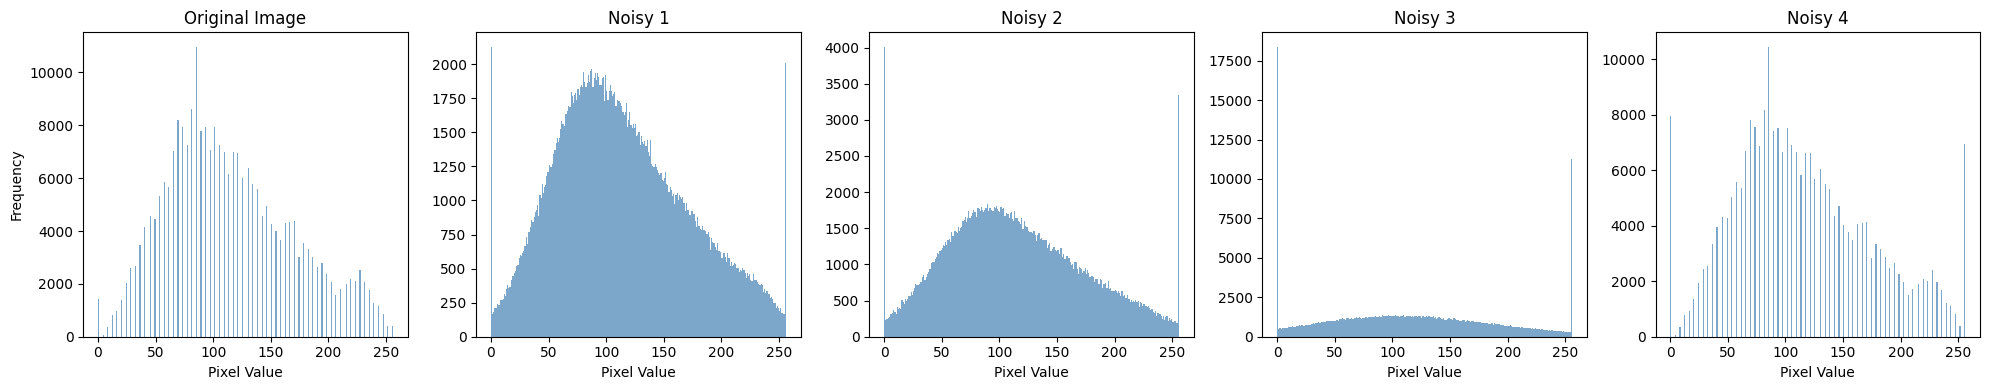

In [109]:
# Plot each noisy image's histogram
plt.figure(figsize=(20, 4))
x_range = [0, 256]
plt.subplot(1, 5, 1)
plt.hist(original_image.ravel(), 256, x_range, alpha=0.7, color = '#4682B4')
plt.title("Original Image")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")

plt.subplot(1, 5, 2)
plt.hist(noisy1_image.ravel(), 256, x_range, alpha=0.7, color = '#4682B4')
plt.title("Noisy 1")
plt.xlabel("Pixel Value")

plt.subplot(1, 5, 3)
plt.hist(noisy2_image.ravel(), 256, x_range, alpha=0.7, color = '#4682B4')
plt.title("Noisy 2")
plt.xlabel("Pixel Value")

plt.subplot(1, 5, 4)
plt.hist(noisy3_image.ravel(), 256, x_range, alpha=0.7, color = '#4682B4')
plt.title("Noisy 3")
plt.xlabel("Pixel Value")

plt.subplot(1, 5, 5)
plt.hist(noisy4_image.ravel(), 256, x_range, alpha=0.7, color = '#4682B4')
plt.title("Noisy 4")
plt.xlabel("Pixel Value")
plt.tight_layout()
plt.show()

## **Demonstration section**

### **PGM image reading**

In [81]:
PGM_types_path = "PGM_types"
PGM_types_list = []
for root, dirs, files in os.walk(PGM_types_path):
    for file in files:
        if file.lower().endswith('.pgm'):
            full_path = os.path.join(root, file)
            PGM_types_list.append(full_path)

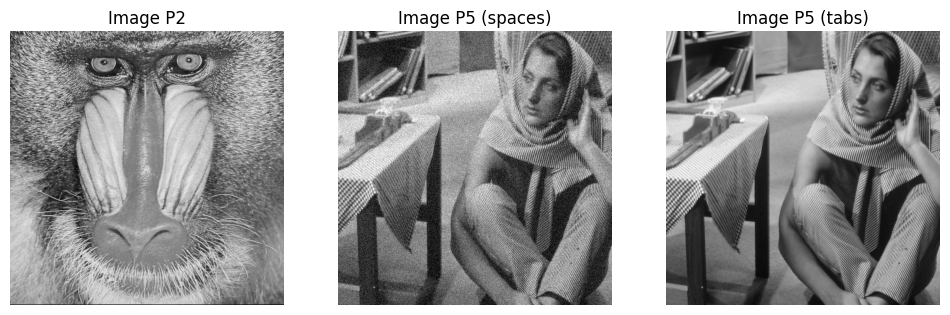

In [82]:
img_label = ['P2', 'P5 (spaces)', 'P5 (tabs)']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for i, image_path in enumerate(PGM_types_list):
    img = read_pgm(image_path)
    axes[i].imshow(img, cmap = 'gray')
    axes[i].set_title(f"Image {img_label[i]}")
    axes[i].axis("off")

### **Wavelet Transform**

This section demonstrates the functional test using two images from the dataset: **Brain1.pgm**, representing an odd image size, and **bridge.pgm**, representing an even image size.

In [83]:
# Path of brain image
brain_path = 'Dataset/original/Brain1.pgm'
brain_image = read_pgm(brain_path)

# Path of bridge image
bridge_path = 'Dataset/original/bridge.pgm'
bridge_image = read_pgm(bridge_path)

Forward discrete wavelet transform

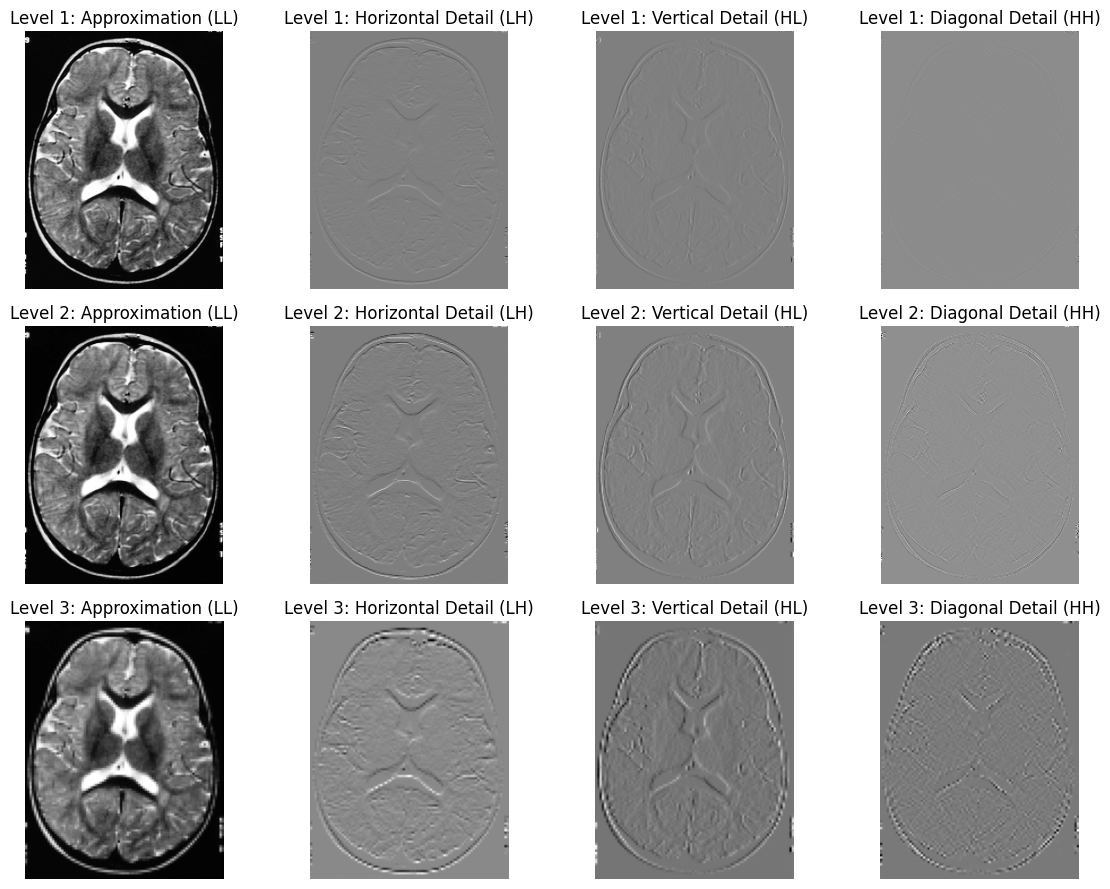

In [84]:
levels = 3
coeffs_brain = FDWT(brain_image, levels)

# Plot all sub-bands for each level
titles = ['Approximation (LL)', 'Horizontal Detail (LH)',
          'Vertical Detail (HL)', 'Diagonal Detail (HH)']

fig, axes = plt.subplots(levels, 4, figsize=(12, 3 * levels))

for level in range(levels):
    LL_img, LH_img, HL_img, HH_img = coeffs_brain[level]
    for i, a in enumerate([LL_img, LH_img, HL_img, HH_img]):
        ax = axes[level, i] if levels > 1 else axes[i]
        ax.imshow(a, cmap='gray')
        ax.set_title(f"Level {level + 1}: {titles[i]}")
        ax.axis('off')

plt.tight_layout()
plt.show()

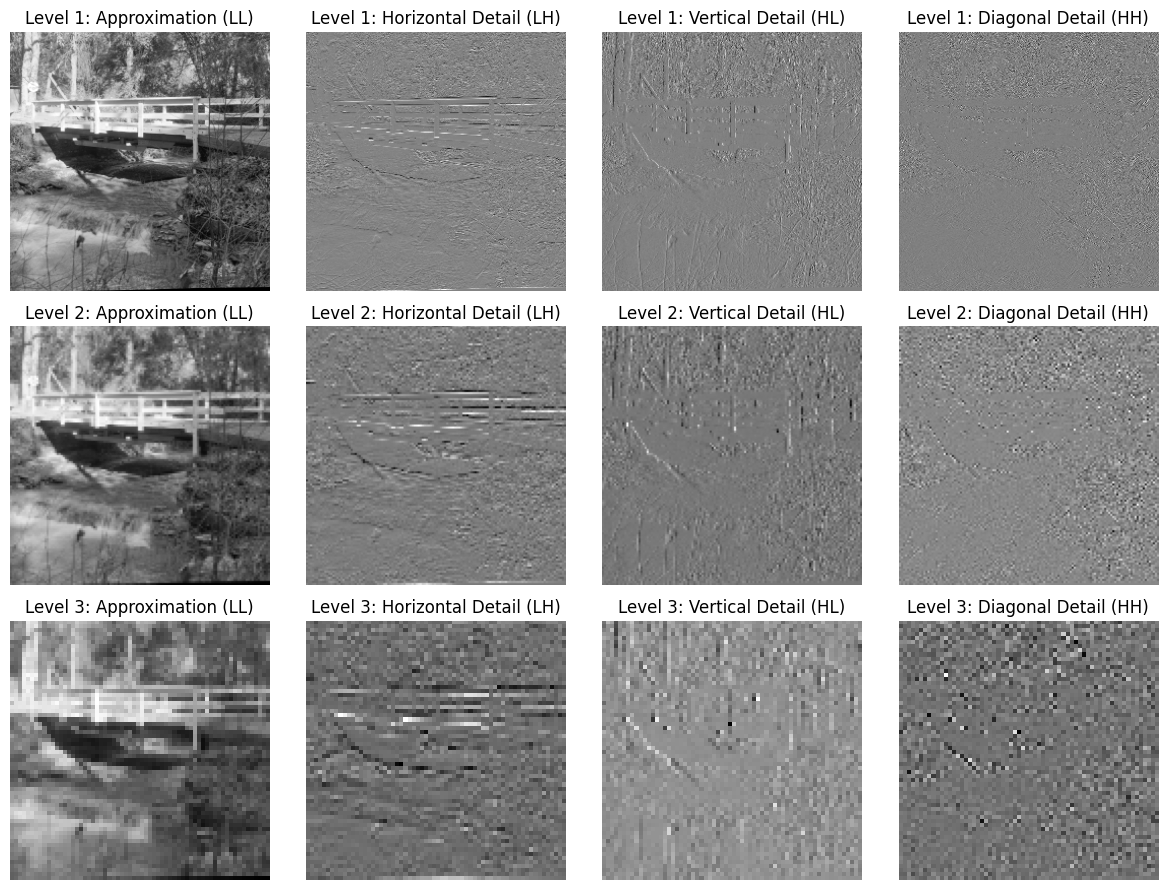

In [85]:
levels = 3
coeffs_bridge = FDWT(bridge_image, levels)

# Plot all sub-bands for each level
titles = ['Approximation (LL)', 'Horizontal Detail (LH)',
          'Vertical Detail (HL)', 'Diagonal Detail (HH)']

fig, axes = plt.subplots(levels, 4, figsize=(12, 3 * levels))

for level in range(levels):
    LL_img, LH_img, HL_img, HH_img = coeffs_bridge[level]
    for i, a in enumerate([LL_img, LH_img, HL_img, HH_img]):
        ax = axes[level, i] if levels > 1 else axes[i]
        ax.imshow(a, cmap='gray')
        ax.set_title(f"Level {level + 1}: {titles[i]}")
        ax.axis('off')

plt.tight_layout()
plt.show()

Inverse discrete wavelet transform

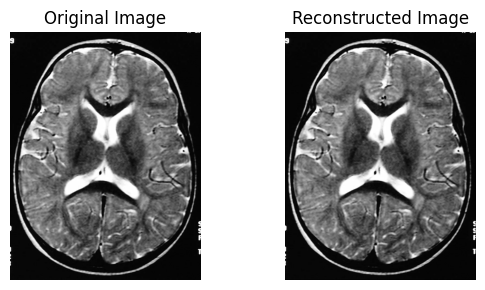

In [86]:
reconstructed_image = IDWT(coeffs_brain)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Display the original image
axes[0].imshow(brain_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the reconstructed image
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Validation

In [87]:
mse, ssim_index, _ = validation(brain_image, reconstructed_image[:brain_image.shape[0], :brain_image.shape[1]])

Mean Squared Error (MSE) between original and reconstructed image: 1.2964840838612008e-26
SSIM Index between original and reconstructed image: 0.9999999999999655


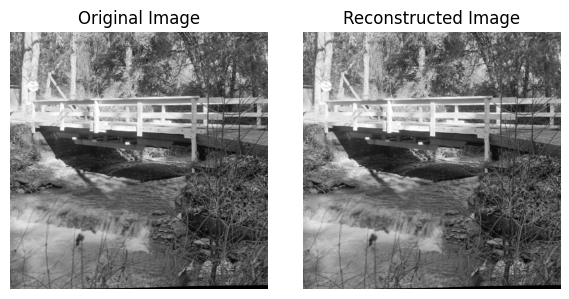

In [88]:
reconstructed_image = IDWT(coeffs_bridge)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Display the original image
axes[0].imshow(bridge_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the reconstructed image
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

Validation

In [89]:
mse, ssim_index, _ = validation(bridge_image, reconstructed_image[:bridge_image.shape[0], :bridge_image.shape[1]])

Mean Squared Error (MSE) between original and reconstructed image: 1.883867561074481e-26
SSIM Index between original and reconstructed image: 1.000000000000009


### **Image denoising**

In [90]:
# Path of images
original_path = 'Dataset/original/bridge.pgm'
original_image = read_pgm(original_path)

noisy1_path = 'Dataset/noisy_1/bridge.pgm'
noisy1_image = read_pgm(noisy1_path)

noisy2_path = 'Dataset/noisy_2/bridge.pgm'
noisy2_image = read_pgm(noisy2_path)

noisy3_path = 'Dataset/noisy_3/bridge.pgm'
noisy3_image = read_pgm(noisy3_path)

noisy4_path = 'Dataset/noisy_4/bridge.pgm'
noisy4_image = read_pgm(noisy4_path)

In [91]:
# Applying denoise function
reconstructed_noisy1, mse_noisy1, ssim_noisy1 = denoise(noisy1_image, original_image, levels = 3)
print('Noisy image 1')
print('Mean Squared Error (MSE) between original and reconstructed image: ', mse_noisy1)
print('SSIM Index between original and reconstructed image: ', ssim_noisy1)
print('')

reconstructed_noisy2, mse_noisy2, ssim_noisy2 = denoise(noisy2_image, original_image, levels = 3)
print('Noisy image 2')
print('Mean Squared Error (MSE) between original and reconstructed image: ', mse_noisy2)
print('SSIM Index between original and reconstructed image: ', ssim_noisy2)
print('')

reconstructed_noisy3, mse_noisy3, ssim_noisy3 = denoise(noisy3_image, original_image, levels = 3)
print('Noisy image 3')
print('Mean Squared Error (MSE) between original and reconstructed image: ', mse_noisy3)
print('SSIM Index between original and reconstructed image: ', ssim_noisy3)
print('')

reconstructed_noisy4, mse_noisy4, ssim_noisy4 = denoise(noisy4_image, original_image, levels = 3)
print('Noisy image 4')
print('Mean Squared Error (MSE) between original and reconstructed image: ', mse_noisy4)
print('SSIM Index between original and reconstructed image: ', ssim_noisy4)

Noisy image 1
Mean Squared Error (MSE) between original and reconstructed image:  67.79154968261719
SSIM Index between original and reconstructed image:  0.6184105340573317

Noisy image 2
Mean Squared Error (MSE) between original and reconstructed image:  74.3249397277832
SSIM Index between original and reconstructed image:  0.5557270069356696

Noisy image 3
Mean Squared Error (MSE) between original and reconstructed image:  88.77203369140625
SSIM Index between original and reconstructed image:  0.36876412614174736

Noisy image 4
Mean Squared Error (MSE) between original and reconstructed image:  49.83267593383789
SSIM Index between original and reconstructed image:  0.7210927613955036
